# Proyecto 2B: practicando el filtrado (también frecuencial)


## 1. Intuición acerca de las convoluciones bidimensionales y el filtrado

### 1.1 Operador de diferencias finitas

Se comenzará usando la diferencia finita en las direcciones $x$ y $y$: $D_x=(1 -1)$ y $D_y=
\begin{pmatrix}
1 \\ -1
\end{pmatrix}
$

Primero, muestre la derivada parcial en $x$ e $y$ de la imagen del camarógrafo (`skimage.data.camera()`) convolucionando la imagen con los operadores de diferencias finitas $D_x$ y $D_y$ (puede usar `scipy.signal.convolve2d`)). Ahora calcule y muestre la imagen de la magnitud del gradiente. Para convertir esto en una imagen de bordes, binarice la imagen de la magnitud del gradiente seleccionando un umbral apropiado (tratando de suprimir el ruido mientras se muestran todos los bordes reales; le tomará algunos intentos encontrar el umbral correcto).

In [241]:
from scipy import signal
from scipy import ndimage
import numpy as np 
import skimage.util
from skimage import data
import matplotlib.pyplot as plt
from skimage import io
import os 
from skimage.color import rgb2gray
from skimage.transform import rescale

In [2]:
Dx = np.array([[1, -1]])
Dy = np.array([[1],[-1]])
print(Dx)
print(Dy)

[[ 1 -1]]
[[ 1]
 [-1]]


In [3]:
astronauta = data.camera()
grad_x = signal.convolve2d(astronauta, Dx,mode='same')
grad_y = signal.convolve2d(astronauta, Dy,mode='same')

grad = np.sqrt(grad_x**2 + grad_y**2)

umbral = 32
grad[grad < umbral] = 0
grad[grad >= umbral] = 255

Text(0.5, 1.0, ' magnitud del Gradiente')

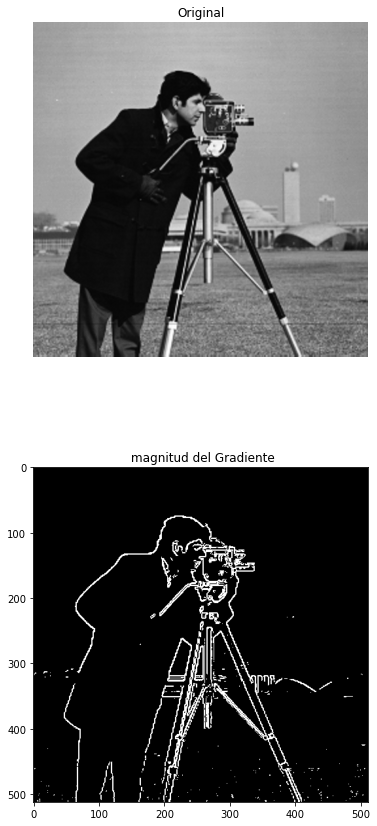

In [4]:
fig, (ax_orig, ax_mag) = plt.subplots(2, 1, figsize=(6, 15))
ax_orig.imshow(astronauta, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_mag.imshow(np.absolute(grad), cmap='gray')
ax_mag.set_title(' magnitud del Gradiente')

### 1.2 Derivada del filtro Gaussiano (DoG)

Antes debió observar que los resultados con solo el operador de diferencia eran bastante ruidosos. Afortunadamente, tenemos un operador de suavizado: el filtro Gaussiano. Cree una versión borrosa de la imagen original convolucionando con un kernel gaussiano y repita el procedimiento de la parte anterior  ¿Qué diferencias ves? Ahora podemos hacer lo mismo con una sola convolución en lugar de dos creando una derivada de filtros gaussianos. Convolucione el kernel gaussiano con $D_x$ y $D_y$ y muestre los filtros DoG resultantes como imágenes. Verifique que el resultado sea el mismo que antes.

Una forma de crear un filtro gaussiano 2D es usando `scipy.signal.gaussian` para crear un gaussiano 1D y luego tomar un producto externo para obtener un kernel gaussiano 2D. Vea el código siguiente:

In [5]:
def gkern(kernlen=21, std=3):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

In [6]:
#kernel gaussiano de dimension nxn y desviacion estandar sd
n = 21
sd = 3
gk = gkern(kernlen=n, std = sd)
# convolucion de kernel gaussiano con Dx
gauss_dx = signal.convolve2d(gk, Dx,mode='same')

# convolucion de kernel gaussiano con Dy
gauss_dy = signal.convolve2d(gk, Dy,mode='same')

Text(0.5, 1.0, ' DoG (direccion y)')

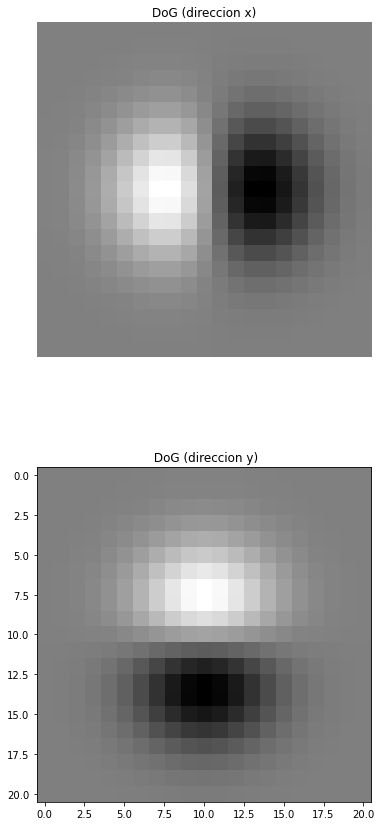

In [7]:
fig, (ax_orig, ax_mag) = plt.subplots(2, 1, figsize=(6, 15))
ax_orig.imshow(gauss_dx, cmap='gray')
ax_orig.set_title('DoG (direccion x)')
ax_orig.set_axis_off()
ax_mag.imshow(gauss_dy, cmap='gray')
ax_mag.set_title(' DoG (direccion y)')

In [8]:
grad_x = signal.convolve2d(astronauta, gauss_dx,mode='same')
grad_y = signal.convolve2d(astronauta, gauss_dy,mode='same')

grad = np.sqrt(grad_x**2 + grad_y**2)

umbral = 150
grad[grad < umbral] = 0
grad[grad >= umbral] = 255

Text(0.5, 1.0, ' magnitud del Gradiente')

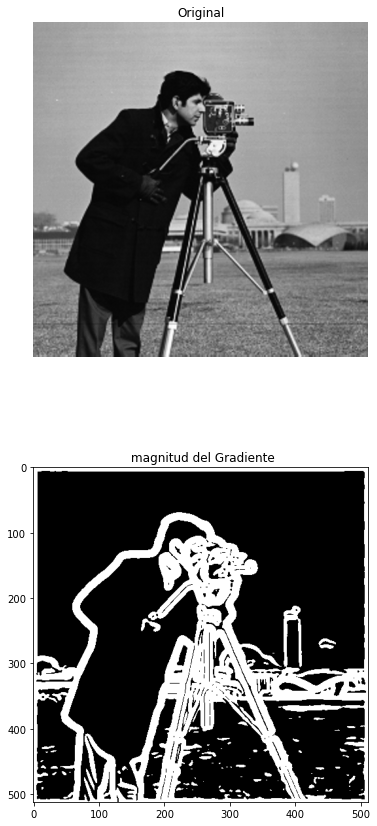

In [9]:
fig, (ax_orig, ax_mag) = plt.subplots(2, 1, figsize=(6, 15))
ax_orig.imshow(astronauta, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_mag.imshow(np.absolute(grad), cmap='gray')
ax_mag.set_title(' magnitud del Gradiente')

### 1.3 Enderezamiento de una imagen

Recuerda la última vez que tomaste una foto con tu teléfono y la imagen no era recta. Probablemente intentaste girar la imagen manualmente para enderezarla. En este problema, se automatizará el proceso de enderezamiento de la imagen para ahorrar algo de tiempo. Se sabe que estadísticamente existe una preferencia por los bordes verticales y horizontales en la mayoría de las imágenes (¡debido a la gravedad!). Usaremos esta información al intentar rotar una imagen para maximizar el número de bordes verticales y horizontales. Para enderezar una imagen, genere un conjunto de rotaciones propuestas. Para cada ángulo de rotación propuesto:

- Gire la imagen según el ángulo de rotación propuesto utilizando la función de rotación incorporada en python (por ejemplo, scipy.ndimage.interpolation.rotate en python).
- Calcule el ángulo del gradiente de los bordes de la imagen (pero ignore los bordes de la imagen creados por la propia rotación; una forma sencilla de hacerlo es recortar siempre la parte central de la imagen).
- Calcule un histograma de estos ángulos (por ejemplo, matplotlib.pyplot.hist en python).

Finalmente, elija la rotación con el número máximo de bordes horizontales y verticales. Muestre el histograma de orientación y el resultado de enderezamiento de la siguiente imagen: ![](images2/facade.jpg)

También muestre su resultado en 3 imágenes más de su elección, de las cuales al menos una debería ser un caso de falla. Para cada imagen, debe mostrar la imagen original, la imagen enderezada y sus histogramas de orientación.
Pruebe a ver si puede mejorar su resultado tal vez usando el dominio de Fourier (esto es opcional extra).

In [10]:
DIR_IMAGES = "images2"
casa = io.imread(os.path.join(DIR_IMAGES, "facade.jpg"))
casa = skimage.util.img_as_float(casa)

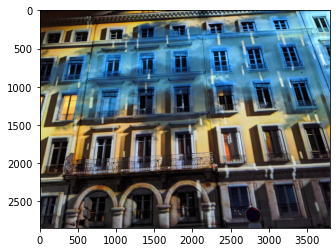

In [11]:
plt.imshow(casa);

In [12]:
def getImagesRot(angulos,imagen):
    imagenesRotadas = []
    for i in angulos:
        casaRotada = ndimage.interpolation.rotate(imagen,i)
        imagenesRotadas.append(casaRotada)
    return imagenesRotadas

angulos = [-1,-3,-5]
casas_rotadas = getImagesRot(angulos, casa)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
<ipython-input-13-d660d44faf66>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


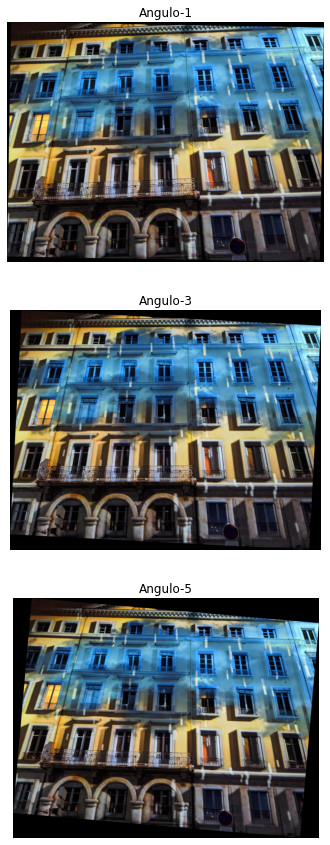

In [13]:
fig, (ax_orig, ax_mag, ax_ang) = plt.subplots(3, 1, figsize=(6, 15))
ax_orig.imshow(casas_rotadas[0])
ax_orig.set_title('Angulo' + str(angulos[0]))
ax_orig.set_axis_off()
ax_mag.imshow(casas_rotadas[1])
ax_mag.set_title('Angulo' + str(angulos[1]))
ax_mag.set_axis_off()
ax_ang.imshow(casas_rotadas[2]) # hsv is cyclic, like angles
ax_ang.set_title('Angulo' + str(angulos[2]))
ax_ang.set_axis_off()
fig.show()

In [14]:
print(casas_rotadas[0].shape)
print(casas_rotadas[1].shape)
print(casas_rotadas[2].shape)

(2915, 3848, 3)
(3044, 3943, 3)
(3169, 4033, 3)


In [15]:
# Imagen recortada con indices seleccionados manualmente
casas_recortadas = []
casas_recortadas.append(casas_rotadas[0][200:2800,200:3800,:])
casas_recortadas.append(casas_rotadas[1][250:2800,200:3800,:])
casas_recortadas.append(casas_rotadas[2][300:2800,200:3800,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
<ipython-input-16-d0ff5e73f4b3>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


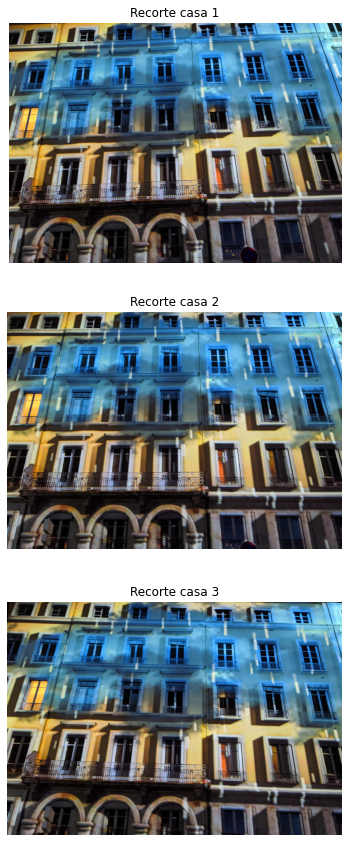

In [16]:
fig, (ax_orig, ax_mag, ax_ang) = plt.subplots(3, 1, figsize=(6, 15))
ax_orig.imshow(casas_recortadas[0])
ax_orig.set_title('Recorte casa 1')
ax_orig.set_axis_off()
ax_mag.imshow(casas_recortadas[1])
ax_mag.set_title('Recorte casa 2')
ax_mag.set_axis_off()
ax_ang.imshow(casas_recortadas[2]) # hsv is cyclic, like angles
ax_ang.set_title('Recorte casa 3')
ax_ang.set_axis_off()
fig.show()

In [17]:
def getGradienteCasa(casas_recortadas):
    angulos_casas = []
    gradientes_casas = []
    for imagen in casas_recortadas:
        gradCasa_x = np.zeros(imagen.shape)
        gradCasa_y = np.zeros(imagen.shape)
        for i in range(3):
            gradCasa_x[:,:,i] = signal.convolve2d(imagen[:,:,i], Dx,mode='same')
            gradCasa_y[:,:,i] = signal.convolve2d(imagen[:,:,i], Dy,mode='same')
        angulos_casas.append((gradCasa_x,gradCasa_y))
        grad_casa = np.sqrt(gradCasa_x**2 + gradCasa_y**2)
        gradientes_casas.append(grad_casa)
    return gradientes_casas,angulos_casas

In [18]:
gradientes_casas, angulos_casas = getGradienteCasa(casas_recortadas)

In [19]:
array_n = []

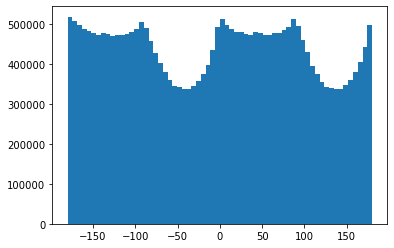

In [20]:
angulo_1 = np.arctan2(angulos_casas[0][0],angulos_casas[0][1])*180/np.pi
n1 = plt.hist(angulo_1.ravel(),bins = 64)
array_n.append(n1)

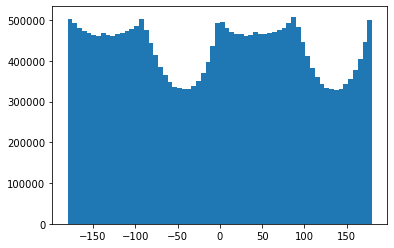

In [21]:
angulo_2 = np.arctan2(angulos_casas[1][0],angulos_casas[1][1])*180/np.pi
n2 = plt.hist(angulo_2.ravel(),bins = 64)
array_n.append(n2)

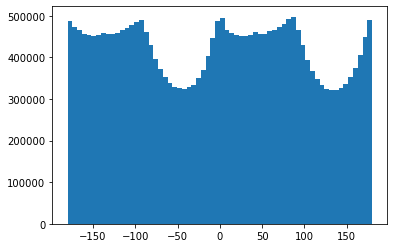

In [22]:
angulo_3 = np.arctan2(angulos_casas[2][0],angulos_casas[2][1])*180/np.pi
n3 = plt.hist(angulo_3.ravel(),bins = 64)
array_n.append(n3)

In [23]:
def getmejorangulo(array_n):
    epsilon = 0.1
    sumAngulos = []
    for i in array_n:
        count = 0
        frec = i[0]
        data = i[1]
        mask1 = ((data >= -180 - 0.1) & (data <= -180 + 0.1))
        mask2 = ((data >= -90 - 0.1) & (data <= -90 + 0.1))
        mask3 = ((data >= 90 - 0.1) & (data <= 90 + 0.1))
        mask4 = ((data >= 180 - 0.1) & (data <= 180 + 0.1))
        index1 = np.where(data == data[mask1])[0][0]
        index2 = np.where(data == data[mask2])[0][0]
        index3 = np.where(data == data[mask3])[0][0]
        index4 = np.where(data == data[mask4])[0][0]
        count = frec[index1] + frec[index2] + frec[index3] + frec[index4 - 1]
        sumAngulos.append(count)
    return sumAngulos.index(max(sumAngulos))

In [24]:
mejorAngulo = getmejorangulo(array_n)
angulos[mejorAngulo]

-1

In [25]:
data = n[1]
#result= np.where(data > 0 - 0.01  and  data < 0 - 0.01)
#result= ((data >= 0 - 0.1) & (data <= 0 + 0.1))
result= ((data >= -180 - 0.1) & (data <= -180 + 0.1))
aux = data[result]
aux2 = np.where(data == aux)
aux2[0][0]

TypeError: 'int' object is not subscriptable

In [ ]:
n3

In [ ]:
x = gradCasa_y/gradCasa_x
angulo = np.arctan(x)
plt.hist(angulo.ravel(),bins = 64)

In [ ]:
#gradCasa_x = np.zeros(casa_rotada1_c.shape)
#gradCasa_y = np.zeros(casa_rotada1_c.shape)

gradCasa_x = signal.convolve2d(casa_rotada3_c[:,:,2], Dx,mode='same')
gradCasa_y = signal.convolve2d(casa_rotada3_c[:,:,2], Dy,mode='same')

grad_casa = np.sqrt(gradCasa_x**2 + gradCasa_y**2)



plt.imshow(grad_casa > 0.06, cmap = 'gray')
plt.colorbar()

In [ ]:
plt.hist(grad_casa.ravel(),bins = 64)

## 2. Frecuencias

### 2.1 Nitidez de la imagen
Escoja una imagen borrosa y prepárese para "enfocarla".  Derive la técnica la técnica de enmascaramiento de enfoque (unsharp masking). El filtro Gaussiano, es un filtro pasabajas que retiene solo las frecuencias bajas. Podemos restar la versión borrosa de la imagen original para obtener las altas frecuencias de la imagen. Una imagen a menudo se ve más nítida si tiene altas frecuencias más fuertes. Entonces, agrega un poco más de frecuencias altas a la imagen. Combine esto en una sola operación de convolución que se denomina unsharp mask filter. Muestre su resultado en la siguiente imagen  más otras imágenes de su elección. ![](images2/taj.jpg)

También para propósistos de evaluación, elija una imagen nítida, difumínela (vuelvala borrosa) y luego intente enfocarla nuevamente. Compare la imagen original y la más nítida e informe sus observaciones.

In [26]:
from skimage import exposure

In [27]:
DIR_IMAGES = "images2"
taj = io.imread(os.path.join(DIR_IMAGES, "taj.jpg"))
taj = skimage.util.img_as_float(taj)

In [28]:
personas = io.imread(os.path.join(DIR_IMAGES, "Personas.jpg"))
personas = skimage.util.img_as_float(personas)

In [29]:
def unsharp_mask_filter(imagen, kerl, desv):
    gk = gkern(kernlen=kerl, std = desv)
    gk = gk/gk.sum()
    imagen_borrosa = np.zeros(imagen.shape)
    for i in range(3):
        imagen_borrosa[:,:,i] = signal.convolve2d(imagen[:,:,i], gk,mode='same')
    imagen_mascara = (imagen - imagen_borrosa)
    imagen_nitida  = imagen + imagen_mascara
    return imagen_nitida,imagen_borrosa

In [30]:
gk = gkern(kernlen=4, std = 0.6)
gk.sum()

2.253512638776652

In [31]:
imag_new,iamg_borr = unsharp_mask_filter(taj,4,0.6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


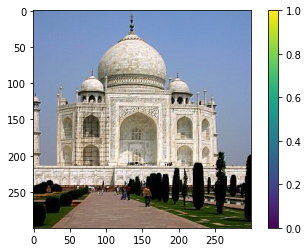

In [32]:
plt.imshow(imag_new)
plt.colorbar()

(array([ 6502.,  2038.,  4569.,  2661.,  7510., 15840., 31118.,  8394.,
         8749.,  2619.]),
 array([0.        , 0.0972149 , 0.1944298 , 0.2916447 , 0.3888596 ,
        0.4860745 , 0.5832894 , 0.6805043 , 0.77771919, 0.87493409,
        0.97214899]),
 <BarContainer object of 10 artists>)

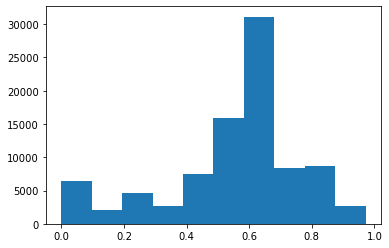

In [33]:
plt.hist(iamg_borr[:,:,1].ravel())

TypeError: Invalid shape (2, 417, 626, 3) for image data

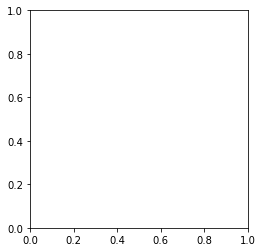

In [34]:
imag_personas = unsharp_mask_filter(personas,5,0.5)
plt.imshow(imag_personas, cmap = 'gray')

In [ ]:
plt.imshow(imag_new, cmap = 'gray')

### 2.2 Imágenes híbridas

#### Introducción 
El objetivo de esta parte de la tarea es crear [imágenes híbridas](http://olivalab.mit.edu/hybrid_gallery/gallery.html) utilizando el enfoque descrito en el [artículo](http://olivalab.mit.edu/publications/OlivaTorralb_Hybrid_Siggraph06.pdf) de Oliva, Torralba y Schyns. Las imágenes híbridas son imágenes estáticas que cambian de interpretación en función de la distancia de visualización. La idea básica es que la alta frecuencia tiende a dominar la percepción cuando está disponible, pero, a distancia, solo se puede ver la parte de baja frecuencia (suave) de la señal. Al combinar la parte de alta frecuencia de una imagen con la parte de baja frecuencia de otra, se obtiene una imagen híbrida que conduce a diferentes interpretaciones en diferentes distancias.

### Implementación
Se incluyen dos imágenes de muestra (gato y einstein) y un código para empezar de python que se puede usar para cargar dos imágenes y alinearlas (`hybrid_image_starter.py`). La alineación es importante porque afecta la agrupación perceptual (lea el paper para obtener más detalles).

1. Primero, necesitará obtener algunos pares de imágenes que desee convertir en imágenes híbridas. Puede usar las imágenes de muestra para depurar, pero debe usar sus propias imágenes en sus resultados. Luego, deberá escribir código para hacer un filtrado pasabajo sobre una imagen, hacer un filtrado pasaalto a la segunda imagen y agregar (o promediar) las dos imágenes. Para un filtro de pasabajo, Oliva et al. sugiera el uso de un filtro gaussiano 2D estándar. Para un filtro  pasaalto, sugieren usar el filtro de impulso menos el filtro gaussiano (que se puede calcular restando la imagen filtrada por Gauss de la original). La frecuencia de corte de cada filtro debe elegirse con cierta experimentación.

2. Para obtener su resultado favorito, también debe ilustrar el proceso a través del análisis de frecuencia. Muestre la magnitud logarítmica de la transformada de Fourier de las dos imágenes de entrada, las imágenes filtradas y la imagen híbrida. En python, puede calcular y mostrar la transformada de Fourier 2D con: 
`plt.imshow (np.log (np.abs (np.fft.fftshift (np.fft.fft2 (gris_ imagen)))))`.

3. Intente crear 2-3 imágenes híbridas (cambio de expresión, transformación entre diferentes objetos, cambio con el tiempo, etc.). Muestre la imagen de entrada y el resultado híbrido por cada ejemplo. (No es necesario mostrar los resultados intermedios como en el paso 2.)

Intente usar color para mejorar el efecto. ¿Funciona mejor usar color para el componente de alta frecuencia, el componente de baja frecuencia o ambos?

El código para ejecutar la imagen híbrida se muestra a continuación. En donde, se debe crear la función de `imagen_hibrida`. Nota: este script realiza la entrada de las coordenadas para alinear usando `ginput` que no funciona sobre jupyter, deberá cambiar este método por algo interactivo en el notebook como los widgets de jupyter.

In [204]:
# alinea las imagenes (pero puede mejorar)
#im1_aligned, im2_aligned = align_images(im1, im2)

## Punto 2.2.1

In [35]:
import matplotlib.pyplot as plt
#%matplotlib notebook
from alinear_imagen import align_images

In [36]:
# Carga las imagenes

# alta frecuencia
im1 = plt.imread('images2/einstein.jpg')/255.
im1 = skimage.img_as_float(im1)
# baja frecuencia
im2 = plt.imread('images2/gato.jpg')/255
im2 = skimage.img_as_float(im2)

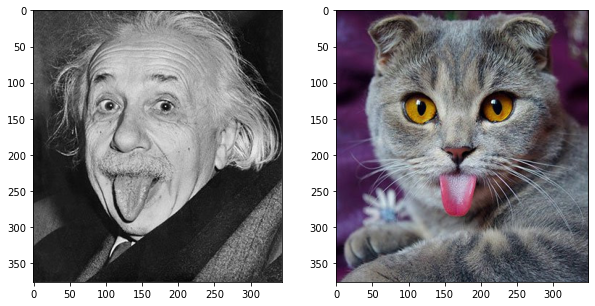

In [203]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(im1);
ax[1].imshow(im2);

In [219]:
def imagen_hibrida(im_1,im_2,sigma1,sigma2):
    # a im 1 se le aplica el filtro pasabajos y a im2 el filtro pasa alto
    gauss_filter = gkern(kernlen=30, std=sigma1)
    gauss_filter = gauss_filter/gauss_filter.sum() # Para que el resultado de las imagenes convolucionadas esté entre 0 y 1
    gauss_filter2 = gkern(kernlen=30, std=sigma2)
    gauss_filter2 = gauss_filter2/gauss_filter2.sum() #
    im1_conv = np.zeros(im_1.shape)
    im2_conv = np.zeros(im_2.shape)
    # NOTA:Para que es sigma2 ?
    for i in range(3):
        im1_conv[:,:,i] = signal.convolve2d(im_1[:,:,i], gauss_filter,mode='same')
        im2_conv[:,:,i] = signal.convolve2d(im_2[:,:,i], gauss_filter2,mode='same')
    #print(im2_conv)
    im2_conv = im_2 - im2_conv
    prom = np.abs(0.5*(im1_conv + im2_conv))
    prom[prom < 0] = 0
    #prom[prom > 1] = 1
    #print(prom)
    print("Intensidad minima: ",prom.min())
    print("Intensidad Maxima: ",prom.max())
    return prom,im1_conv, im2_conv

Intensidad minima:  6.353468625514003e-08
Intensidad Maxima:  0.765499879474002


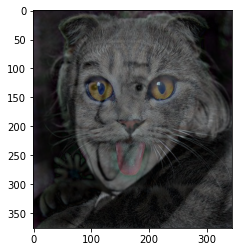

In [226]:
## Deberas realizar el codigo de imagen_hibrida. Sigma1 and sigma2 son valores de corte arbitrarios para
## las bajas y altas frecuencias
sigma1 = 1.2
sigma2 = 15
hybrid,im1_conv,im2_conv = imagen_hibrida(im1[:,:344,:], im2[:,:344,:], sigma1, sigma2)

plt.imshow(hybrid)
plt.show()

## Punto 2.2

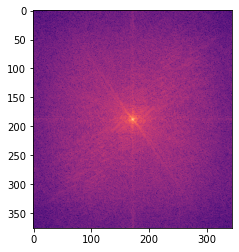

In [232]:
# Transformda de Fourier para imagen 1
im1_g = rgb2gray(im1)
im1_f = np.log (np.abs (np.fft.fftshift (np.fft.fft2 (im1_g))))
plt.imshow(im1_f,cmap="magma");

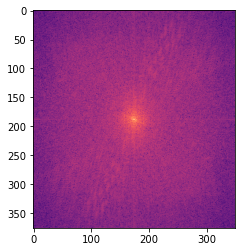

In [235]:
# Transformda de Fourier para imagen 2
im2_g = rgb2gray(im2)
im2_f = np.log (np.abs (np.fft.fftshift (np.fft.fft2 (im2_g))))
plt.imshow(im2_f,cmap="magma");

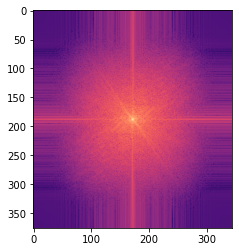

In [237]:
# Transformda de Fourier para imagen 1 convolucionada
im1_c_g = rgb2gray(im1_conv)
im1_conv_f = np.log (np.abs (np.fft.fftshift (np.fft.fft2 (im1_c_g))))
plt.imshow(im1_conv_f,cmap="magma");

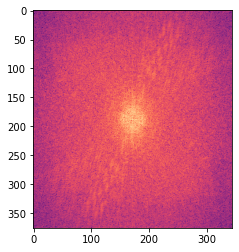

In [238]:
# Transformda de Fourier para imagen 2 convolucionada
im2_c_g = rgb2gray(im2_conv)
im2_conv_f = np.log (np.abs (np.fft.fftshift (np.fft.fft2 (im2_c_g))))
plt.imshow(im2_conv_f,cmap="magma");

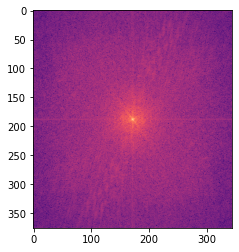

In [239]:
# Transformda de Fourier para imagen hibrida
hibrida_g = rgb2gray(hybrid)
hibrida_f = np.log (np.abs (np.fft.fftshift (np.fft.fft2 (hibrida_g))))
plt.imshow(hibrida_f,cmap="magma");

# 2.2.3

In [271]:
#im_r = rescale(imagen, 0.25, anti_aliasing=True, multichannel=True)
DIR_IMAGES = "images2"
im3 = io.imread(os.path.join(DIR_IMAGES, "perro.jpg"))
im3 = rescale(im3, 0.33, anti_aliasing=True, multichannel=True)
im3 = skimage.img_as_float(im3)

im4 = io.imread(os.path.join(DIR_IMAGES, "snoop_dogg.jpg"))
im4 = rescale(im4, 0.33, anti_aliasing=True, multichannel=True)
im4 = skimage.img_as_float(im4)

im5 = io.imread(os.path.join(DIR_IMAGES, "sonrisa.jpg"))
im5 = rescale(im5, 0.125, anti_aliasing=True, multichannel=True)
im5 = skimage.img_as_float(im5)

im6 = io.imread(os.path.join(DIR_IMAGES, "serio.jpg"))
im6 = rescale(im6, 0.125, anti_aliasing=True, multichannel=True)
im6 = skimage.img_as_float(im6)

In [280]:
im3 = im3[:111,:90,:]
#im5.shape #(816, 612, 3)
#print(im3.shape)

(111, 90, 3)
(111, 90, 3)
(816, 612, 3)
(816, 612, 3)
(111, 90, 3)


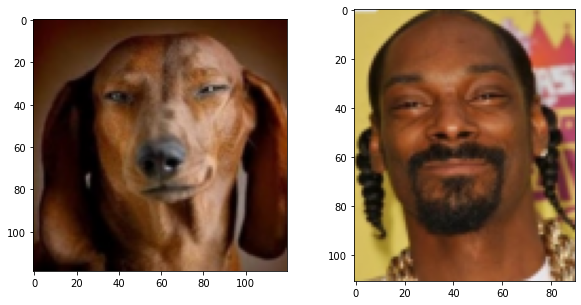

In [277]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(im3);
ax[1].imshow(im4);

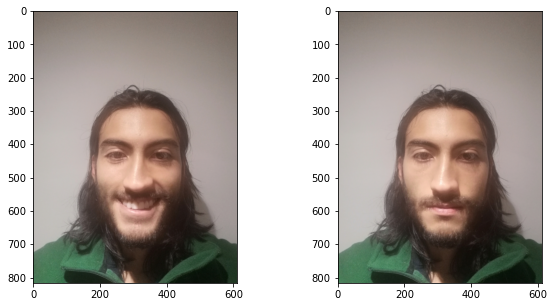

In [276]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(im5);
ax[1].imshow(im6);

Intensidad minima:  1.757095386932528e-07
Intensidad Maxima:  0.5978440210140078


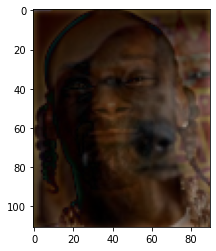

In [304]:
# Segunda imagen hibrida
sigma1 = 0.09
sigma2 = 2
hybrid2,im3_conv,im4_conv = imagen_hibrida(im3, im4, sigma1, sigma2)

plt.imshow(hybrid2)
plt.show()

Intensidad minima:  4.507578172223935e-05
Intensidad Maxima:  0.5172591979341147


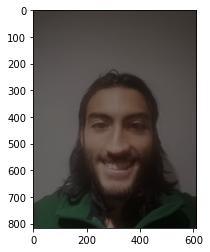

In [319]:
sigma1 = 0.03
sigma2 = 0.6
hybrid3,im5_conv,im6_conv = imagen_hibrida(im5, im6, sigma1, sigma2)

plt.imshow(hybrid3)
plt.show()

## Entregables

Para este proyecto debera entregar el desarrollo y visualización de los resultados en un notebook de jupyter donde se muestre el código realizado (y las pruebas). También, debe entregar un pequeño informe del proyecto con una breve descripción del proyecto explicando el enfoque desarrollado y el análisis de los resultados .(Puede ser otro notebook, pero sin código, o un documento en PDF).

Es aconsejable en el notebook solo mostrar las imágenes (resultados) en un formato comprimido (jpg por ejm).  Muestre los resultados mostrando las imagenes originales y las posteriores al procedimiento. 
Si algún resultado no es bueno, explique por qué sucede esto. Describa cualquier idea extra implementada. 